<a href="https://colab.research.google.com/github/PatrizioPerugini/MOD_VISIOPE/blob/main/proj_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GIT CLONE

In [1]:
#Clone git repository
!git clone https://github.com/PatrizioPerugini/MOD_VISIOPE.git

Cloning into 'MOD_VISIOPE'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 26 (delta 7), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (26/26), done.


#IMPORT

In [ ]:
#zip the file
import zipfile


zip_ref = zipfile.ZipFile('/content/MOD_VISIOPE/Chess_ds_N.coco.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content/MOD_VISIOPE') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys

In [ ]:
#import pytorch 
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
#import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

In [ ]:
%cd /content/MOD_VISIOPE/
%ls

/content/MOD_VISIOPE
Chess_ds.coco.zip      project.ipynb       README.md            train/
Chess_ds_N.coco.zip    proj_vision.ipynb   README.roboflow.txt  valid/
Chess_ds_new.coco.zip  README.dataset.txt  test/                weights/


In [ ]:
!pip install -U torchvision 

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0+cu113
0.12.0+cu113


In [ ]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
#For the moment we are having some troubles, so we are not using it
!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# LOAD AND PREPROCESS THE DATASET

In [ ]:
#Just define a function that transforms our input data
def get_transforms(train=False):
   transform = A.Compose([
            A.Resize(600, 600), # A.Resize(512, 512)
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
   return transform

In [ ]:
class Chess_ds(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
       
        super().__init__(root, transforms, transform, target_transform)
        self.split = split 
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] 
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            ymin = box[1]
            xmax = xmin + box[2]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} 
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) 
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
#load classes
dataset_path = "/content/MOD_VISIOPE/"
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


{0: {'id': 0, 'name': 'Chess', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'bishop', 'supercategory': 'Chess'},
 2: {'id': 2, 'name': 'black-bishop', 'supercategory': 'Chess'},
 3: {'id': 3, 'name': 'black-king', 'supercategory': 'Chess'},
 4: {'id': 4, 'name': 'black-knight', 'supercategory': 'Chess'},
 5: {'id': 5, 'name': 'black-pawn', 'supercategory': 'Chess'},
 6: {'id': 6, 'name': 'black-queen', 'supercategory': 'Chess'},
 7: {'id': 7, 'name': 'black-rook', 'supercategory': 'Chess'},
 8: {'id': 8, 'name': 'white-bishop', 'supercategory': 'Chess'},
 9: {'id': 9, 'name': 'white-king', 'supercategory': 'Chess'},
 10: {'id': 10, 'name': 'white-knight', 'supercategory': 'Chess'},
 11: {'id': 11, 'name': 'white-pawn', 'supercategory': 'Chess'},
 12: {'id': 12, 'name': 'white-queen', 'supercategory': 'Chess'},
 13: {'id': 13, 'name': 'white-rook', 'supercategory': 'Chess'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Chess',
 'bishop',
 'black-bishop',
 'black-king',
 'black-knight',
 'black-pawn',
 'black-queen',
 'black-rook',
 'white-bishop',
 'white-king',
 'white-knight',
 'white-pawn',
 'white-queen',
 'white-rook']

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
#create train
train_dataset = Chess_ds(root=dataset_path, transforms=get_transforms(False))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
#create validation
validation_dataset = Chess_ds(root=dataset_path, split="valid", transforms=get_transforms(False))
valid_dl = DataLoader(validation_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
print(valid_dl)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


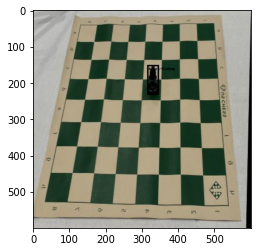

In [ ]:
# As good practice, let's view a sample!
sample = train_dataset[torch.randint(1,606,(1,))]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

580

# CUSTOM ARCHITECTURE

Try to use a pre-trained resnet 34

In [ ]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 14))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)


In [ ]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=10000):
    idx = 0
    num_classes=14
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, targets in tqdm(train_dl):
            #y_class=[]
            y_bb=[]
            x  = torch.stack(list(x), dim=0)
            batch = x.shape[0]
            y_target=torch.zeros((batch,num_classes)).cuda()#batch , num classes
            tot_bb = []
            max_num_bb = 0
            bs=0
            x = x.cuda().float()
            out_class, out_bb = model(x)
            for t in targets:
              y_bb.append(t['boxes'])
              #y_class.append(t['labels'])
              num_bb = t['boxes'].shape[0]
              if (num_bb > max_num_bb):
                max_num_bb = num_bb   
              tot_bb.append(num_bb)

              for i in range(len(t['labels'])):
                y_target[bs][t['labels'][i]]+=1
              bs+=1
            
            y_target = y_target.softmax(dim=1)
           
            y_target_bb = torch.zeros((batch, max_num_bb, 4)).cuda()
                       
            for i in range(batch):
              cnt = 0
              while (cnt<tot_bb[i]):
                y_target_bb[i][cnt][0] = y_bb[i][cnt][0]
                y_target_bb[i][cnt][1] = y_bb[i][cnt][1]
                y_target_bb[i][cnt][2]= y_bb[i][cnt][2]
                y_target_bb[i][cnt][3] = y_bb[i][cnt][3]
                cnt+=1

            loss_bb=0
            for i in range(max_num_bb):
                #print(y_target_bb[:,i,:].squeeze(1).shape)
                y_t_bb=y_target_bb[:,i,:].squeeze(1)
                loss_bb += F.l1_loss(out_bb, y_t_bb, reduction="none").sum(1)
            
            #maybe statistician
            loss_bb =loss_bb.sum()
            print("loss bb is: ",loss_bb)
            
            #loss for classes

            loss_class = F.cross_entropy(out_class, y_target, reduction="sum")

            print("loss class is: ",loss_class)
            loss = loss_class + loss_bb/C
            print("total loss is: ",loss)
            #optimize the loss and update the weights
            frefg
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            idx += 1
            total += batch
            sum_loss += loss.item()
        
        torch.save(model.state_dict(), "/content/MOD_VISIOPE/weights/custom_model.pt")
        train_loss = sum_loss/total
        #val_loss, val_acc = val_metrics(model, valid_dl, C)
        #print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total  
   


In [ ]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, targets in valid_dl:
        y_class=[]
        y_bb=[]
        for t in targets:
            y_bb.append(t['boxes'])
            y_class.append(t['labels'])
            
        batch = len(x)
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [ ]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.05)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
train_epocs(model, optimizer, train_loader, valid_dl, epochs=1)

  0%|          | 0/145 [00:00<?, ?it/s]

loss bb is:  tensor(43878.5781, device='cuda:0', grad_fn=<SumBackward0>)
loss class is:  tensor(8.0774, device='cuda:0', grad_fn=<NegBackward0>)
total loss is:  tensor(12.4653, device='cuda:0', grad_fn=<AddBackward0>)


NameError: ignored

# CHOOSE A FASTER R-CNN

In [ ]:
# lets load the faster rcnn model with mobilenetV3
weight_path = "/content/MOD_VISIOPE/weights/prova.pt"

model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

#TO BE FIXED
#model.load_state_dict(torch.load(weight_path))

In [ ]:
# lets load the faster rcnn model with ResNet
weight_path = "/content/MOD_VISIOPE/weights/prova2.pt"

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)


#model.load_state_dict(torch.load(weight_path))

In [ ]:
# lets load the mask rcnn model with ResNet
weight_path = "/content/MOD_VISIOPE/weights/prova3.pt"

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)


#model.load_state_dict(torch.load(weight_path))

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
# lets load the faster R-CNN model with mobilenetV3 large
weight_path = "/content/MOD_VISIOPE/weights/prova4.pt"

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)


#model.load_state_dict(torch.load(weight_path))



Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]

output = model(images, targets) 

targets = [{k: torch.tensor(v) for k, v in t.items()} for t in targets]

In [ ]:
device = torch.device("cuda") # use GPU to train

In [ ]:
model = model.to(device)

# OPTIMIZER

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
#we can try and change the optimizer or its parameters but it works just fine
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
#we can train with small number of epochs, we'll save each intermediate weights
num_epochs=5

In [ ]:
def fit(model, optimizer, loader, devic,val,num_epochs):
    model.to(device)
    model.train()
    loss_4plot = []
    loss_class_4plot = []
    loss_box_4plot = []
    loss_val_4plot = []
    loss_class_val_4plot = []
    loss_box_val_4plot = []

    for epoch in range(num_epochs):
      all_losses = []
      all_losses_dict = []
      all_losses_v = []
      all_losses_dict_v = []
      #
      for images, targets in tqdm(loader):
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
          loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
        
          all_losses.append(loss_value)
          all_losses_dict.append(loss_dict_append)
        
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
     
      #METODO DELLA SCIMMIA, TRY TO IMPROVE.....VALIDATION
      for images, targets in (val):
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
          loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
        
          all_losses_v.append(loss_value)
          all_losses_dict_v.append(loss_dict_append)
      
      all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
      print("Epoch {}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
            epoch,np.mean(all_losses),
            all_losses_dict['loss_classifier'].mean(),
            all_losses_dict['loss_box_reg'].mean(),
            all_losses_dict['loss_rpn_box_reg'].mean(),
            all_losses_dict['loss_objectness'].mean()
            
       ))
      
      loss_4plot.append(np.mean(all_losses))
      loss_class_4plot.append(all_losses_dict['loss_classifier'].mean())
      loss_box_4plot.append(all_losses_dict['loss_box_reg'].mean())

      all_losses_dict_v = pd.DataFrame(all_losses_dict_v) # for printing
      print("Epoch {}, loss_val: {:.6f}, loss_classifier_val: {:.6f}, loss_box_val: {:.6f}, loss_rpn_box_val: {:.6f}, loss_object_v: {:.6f}".format(
            epoch,np.mean(all_losses_v),
            all_losses_dict_v['loss_classifier'].mean(),
            all_losses_dict_v['loss_box_reg'].mean(),
            all_losses_dict_v['loss_rpn_box_reg'].mean(),
            all_losses_dict_v['loss_objectness'].mean()
            
       ))
      
      loss_val_4plot.append(np.mean(all_losses_v))
      loss_class_val_4plot.append(all_losses_dict_v['loss_classifier'].mean())
      loss_box_val_4plot.append(all_losses_dict_v['loss_box_reg'].mean())
      


      torch.save(model.state_dict(), weight_path)
      
    ep = np.arange(0, num_epochs, 1, dtype=int)

    plt.plot(ep, loss_4plot, label = "loss on trainig")
    plt.plot(ep, loss_val_4plot, label = "loss on validation")
    plt.plot(ep, loss_class_4plot, label = "class. loss on trainig")
    plt.plot(ep, loss_class_val_4plot, label = "class. loss on validation")
    plt.plot(ep, loss_box_4plot, label = "box loss on trainig")
    plt.plot(ep, loss_box_val_4plot, label = "box loss on trainig")
    plt.legend()
    plt.show()    

In [ ]:
def fitt(model, optimizer, loader, device,num_epochs):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
      all_losses = []
      all_losses_dict = []
      for images, targets in tqdm(loader):
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
          loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
        
          all_losses.append(loss_value)
          all_losses_dict.append(loss_dict_append)
        
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
      
      all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
      print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
            epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
            all_losses_dict['loss_classifier'].mean(),
            all_losses_dict['loss_box_reg'].mean(),
            all_losses_dict['loss_rpn_box_reg'].mean(),
            all_losses_dict['loss_objectness'].mean()
       ))
      torch.save(model.state_dict(), weight_path)
      

100%|██████████| 145/145 [00:20<00:00,  7.23it/s]


Epoch 0, loss: 0.724527, loss_classifier: 0.237223, loss_box: 0.477094, loss_rpn_box: 0.006103, loss_object: 0.004107
Epoch 0, loss_val: 0.715468, loss_classifier_val: 0.225630, loss_box_val: 0.484412, loss_rpn_box_val: 0.003524, loss_object_v: 0.001901


100%|██████████| 145/145 [00:20<00:00,  7.23it/s]


Epoch 1, loss: 0.707637, loss_classifier: 0.230106, loss_box: 0.467654, loss_rpn_box: 0.005767, loss_object: 0.004111
Epoch 1, loss_val: 0.672661, loss_classifier_val: 0.214759, loss_box_val: 0.451559, loss_rpn_box_val: 0.003604, loss_object_v: 0.002738


100%|██████████| 145/145 [00:20<00:00,  7.24it/s]


Epoch 2, loss: 0.671330, loss_classifier: 0.207656, loss_box: 0.454359, loss_rpn_box: 0.005518, loss_object: 0.003796
Epoch 2, loss_val: 0.791337, loss_classifier_val: 0.227791, loss_box_val: 0.557538, loss_rpn_box_val: 0.003990, loss_object_v: 0.002018


100%|██████████| 145/145 [00:19<00:00,  7.31it/s]


Epoch 3, loss: 0.690009, loss_classifier: 0.211597, loss_box: 0.469338, loss_rpn_box: 0.005440, loss_object: 0.003634
Epoch 3, loss_val: 0.857959, loss_classifier_val: 0.275552, loss_box_val: 0.576854, loss_rpn_box_val: 0.003157, loss_object_v: 0.002396


100%|██████████| 145/145 [00:20<00:00,  7.21it/s]


Epoch 4, loss: 0.715710, loss_classifier: 0.214205, loss_box: 0.492624, loss_rpn_box: 0.005374, loss_object: 0.003507
Epoch 4, loss_val: 0.676902, loss_classifier_val: 0.240310, loss_box_val: 0.429792, loss_rpn_box_val: 0.003623, loss_object_v: 0.003177


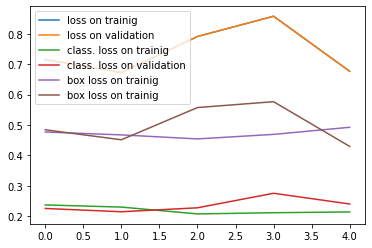

In [ ]:
#fit the model 
fit(model, optimizer, train_loader, device,valid_dl,num_epochs=5 )
#fitt(model, optimizer, train_loader, device,num_epochs=2 )
#decide whether it's necessary here too...I don't think so 
torch.save(model.state_dict(), weight_path)

In [ ]:
#Just to get a peek... don't run :)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


# EVALUATE

In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = Chess_ds(root=dataset_path, split="test", transforms=get_transforms(False))
len(test_dataset)
#model(images, targets)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


32

In [ ]:

def accuracy_class(out,yb):
  
  #preds = torch.argmax(out,dim=1)
  return (out==yb).float().mean()



tensor([5])


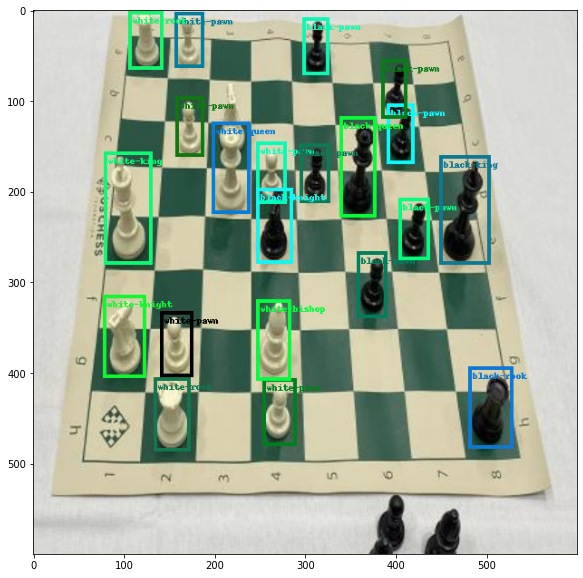

In [ ]:
i =torch.randint(1,28,(1,))
#23 bella
print(i)
img, _ = test_dataset[i]
#img, _ = test_dataset[26]
#22 - 26 
img_int = torch.tensor(img*255, dtype=torch.uint8)


#since we don't have to compute the loss we don't require the gradients to be computed
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
#VIDEO CAPTURING FOR REAL TIME APPLICATIONS
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture('/content/MOD_VISIOPE/video_prova.mp4')#MOV

count = 0
while cap.isOpened():
    ret,frame = cap.read()
    cv2_imshow(frame)
    cv2.imwrite("frame%d.jpg" % count, frame)
    count = count + 1
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows() # destroy all opened windows




AttributeError: ignored

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/videos/video_prova.mp4"

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
#CUSTOM NET
i =torch.randint(1,28,(1,))
print(i)
img, _ = test_dataset[i]
#img, _ = test_dataset[16]
#22 - 26 
img_int = torch.tensor(img*255, dtype=torch.uint8)
print(img.shape)


#since we don't have to compute the loss we don't require the gradients to be computed
with torch.no_grad():
    
    #this one works for fast rcnn
   
    prediction, bb = model(img.unsqueeze(0).to(device))
    print(bb)
    pred = prediction[0]
print(prediction.softmax(dim=1))
print(bb)

fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,bb,"b").permute(1,2,0))


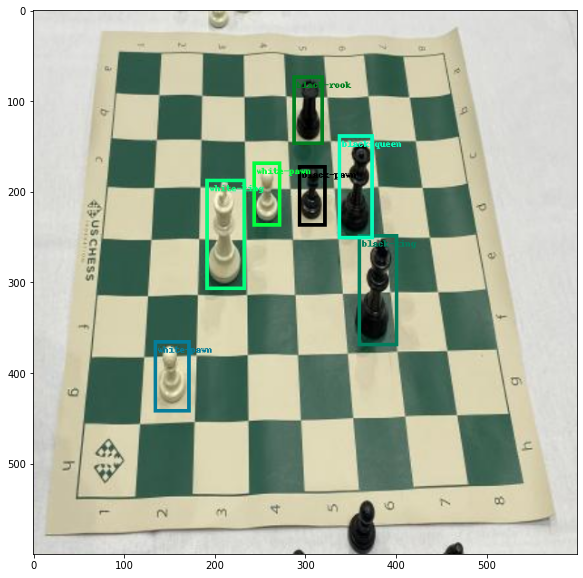

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))